In [7]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = GAT
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb


    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [68]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 8,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings 
        # BEFORE message passing.
        # Pay attention to dimensions of the linear layers, since we're using 
        # multi-head attention.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        self.lin_l = nn.Linear(self.in_channels, self.out_channels * self.heads)
        ############################################################################

        self.lin_r = self.lin_l

        ############################################################################
        # TODO: Your code here! 
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear
        # Our implementation is ~2 lines, but don't worry if you deviate from this.

        self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that 
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing. 
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of N * d.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.

        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)
        alpha_l = self.att_l * x_l
        alpha_r = self.att_r * x_r
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), size=size)
        out = out.reshape(-1, H*C)
        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function. Putting the attention in message 
        # instead of in update is a little tricky.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use 
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape E * H * d.
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # Our implementation is ~5 lines, but don't worry if you deviate from this.

        alpha = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)
        if ptr:
            att_weight = F.softmax(alpha_i + alpha_j, ptr)
        else:
            att_weight = torch_geometric.utils.softmax(alpha_i + alpha_j, index)
        att_weight = F.dropout(att_weight, p=self.dropout)
        out = att_weight * x_j

        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        out = torch_scatter.scatter(inputs, index, self.node_dim, dim_size=dim_size, reduce='sum')
        ############################################################################
    
        return out

In [3]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [4]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt
import torch_geometric

In [124]:
def train(num_node_features,num_classes,train_mask,args):
    
    #print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    #test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(num_node_features, args.hidden_dim, num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[train_mask]
            label = label[train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)
        test_acc = test(test_loader, model)
        test_accs.append(test_acc)
        if epoch % 1 == 0:
          #test_acc = test(test_loader, model)
          #test_accs.append(test_acc)
            print("Epoch ", epoch, "Loss: ", total_loss, "Test Acc.: ", test_acc)
        #else:
         # test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [43]:
dataset = Planetoid(root='/tmp/cora', name='Cora')
test_loader = loader = DataLoader(dataset, batch_size=32, shuffle=True)
for data in loader:
    print(data)
args={'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 3, 'heads': 2, 
         'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 100, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.01}
args = objectview(args)
test_accs, losses = train(dataset.num_node_features,dataset.num_classes,data.train_mask,args)
print("Maximum accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))


DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], batch=[2708], ptr=[2])
Epoch  0 Loss:  1.951323390007019 Test Acc.:  0.17
Epoch  10 Loss:  1.4059704542160034 Test Acc.:  0.364
Epoch  20 Loss:  0.3874613046646118 Test Acc.:  0.608
Epoch  30 Loss:  0.2111172080039978 Test Acc.:  0.716
Epoch  40 Loss:  0.09816200286149979 Test Acc.:  0.71
Epoch  50 Loss:  0.08302515000104904 Test Acc.:  0.696
Epoch  60 Loss:  0.08721401542425156 Test Acc.:  0.73
Epoch  70 Loss:  0.10012725740671158 Test Acc.:  0.712
Epoch  80 Loss:  0.06463880836963654 Test Acc.:  0.722
Epoch  90 Loss:  0.05699240043759346 Test Acc.:  0.73
Maximum accuracy: 0.73
Minimum loss: 0.04928265139460564


In [45]:
x_dom=data.x
print(x_dom)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [46]:
import pandas as pd
import numpy as np

df_data = pd.read_csv('Feature_cora.csv')

df_data.head()

,Unnamed: 0,a_0,b_0,a_1,b_1,a_2,b_2,a_3,b_3,a_4,...,S_5,S_6,In_0,In_1,In_2,In_3,In_4,In_5,In_6,Class
0,0,1,0,155,3,5,0,0,0,4,...,2,1,16,20,20,16,17,12,14,1
1,1,0,0,3,1,0,0,0,0,0,...,7,4,16,18,18,17,15,16,15,1
2,2,0,0,0,0,1,0,1,0,40,...,3,1,10,11,12,10,12,7,8,4
3,3,0,0,0,0,0,0,3,0,14,...,2,5,13,17,19,18,20,14,18,4
4,4,0,0,0,0,0,1,0,0,4,...,2,3,17,17,19,17,20,15,17,4


In [48]:
data_c=df_data.drop(['Unnamed: 0','Class'], axis=1)
data_c.head()

,a_0,b_0,a_1,b_1,a_2,b_2,a_3,b_3,a_4,b_4,...,S_4,S_5,S_6,In_0,In_1,In_2,In_3,In_4,In_5,In_6
0,1,0,155,3,5,0,0,0,4,0,...,3,2,1,16,20,20,16,17,12,14
1,0,0,3,1,0,0,0,0,0,0,...,6,7,4,16,18,18,17,15,16,15
2,0,0,0,0,1,0,1,0,40,0,...,4,3,1,10,11,12,10,12,7,8
3,0,0,0,0,0,0,3,0,14,0,...,8,2,5,13,17,19,18,20,14,18
4,0,0,0,0,0,1,0,0,4,3,...,8,2,3,17,17,19,17,20,15,17


In [49]:
De=data_c.to_numpy()
Fe=np.array(De,dtype="f")

In [50]:
import numpy as np

p_data = open("/Users/joshem/PhD Research/Data/cora/cora.cites")


# Create a list from the data
myls=list(p_data)

# Remove the new line symbole from the list
mylist = [line.rstrip('\n') for line in myls]
#print(mylist)
#print(graph_ind)
#print(graph_level)

p_data.close()

In [51]:
mynode=[]
Edgelist=[]
i=0
for d in mylist:
    d=mylist[i].split("\t")
    mynode.append(int(d[0]))
    mynode.append(int(d[1]))
    Edgelist.append([int(d[0]),int(d[1])])
    i=i+1
#print(mynode)
node_ID1=np.unique(mynode)
node_ID=list(node_ID1)
#print(node_ID)
n=len(node_ID)
print(n)

2708


In [52]:

edgelist=[]
i=0
for d in mylist:
    d=mylist[i].split("\t")
    edgelist.append([node_ID.index(int(d[0])),node_ID.index(int(d[1]))])
    i=i+1
#print(edgelist)

In [102]:
train=[True, False, True, True, False, False, False, False, False, True, False, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, False, False, False, False, False, True, False, False, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, False, True, True, True, True, True, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, True, False, True, True, True, False, True, True, False, True, True, False, False, True, True, True, True, False, True, True, False, True, True, False, False, False, False, True, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, True, False, False, False, True, True, False, True, False, False, True, False, True, True, True, False, False, False, True, False, True, True, False, True, True, True, True, False, False, True, True, True, True, True, True, False, True, True, False, True, True, False, True, True, True, False, False, True, False, False, False, False, True, True, True, False, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, False, True, True, True, True, True, False, True, True, False, False, True, True, False, False, False, False, True, True, True, False, False, True, True, True, True, False, True, True, True, True, False, False, True, True, False, True, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, False, True, True, True, False, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, False, True, False, True, False, True, False, True, True, True, True, False, False, True, True, True, True, False, True, True, False, True, False, False, False, True, True, True, True, True, True, True, True, False, False, True, True, False, False, True, False, True, True, False, False, True, True, False, True, True, True, True, False, False, True, False, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, False, True, True, False, True, True, False, False, True, True, True, True, False, True, True, False, True, True, False, True, False, True, True, False, True, True, True, False, False, False, True, True, True, False, True, True, True, True, True, False, True, False, False, True, False, False, False, True, False, True, False, False, True, False, False, True, True, True, False, False, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, False, False, False, False, False, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, False, True, False, True, True, True, True, False, True, False, True, False, False, False, False, True, False, False, True, False, True, False, True, True, True, True, False, True, True, False, True, False, True, True, True, False, True, True, True, True, True, False, False, True, True, True, False, True, False, True, False, False, True, False, True, True, True, True, False, False, True, True, False, True, True, False, True, False, True, True, True, True, False, True, True, True, True, True, False, False, True, False, False, True, True, True, True, False, True, False, False, True, False, True, True, True, False, True, True, True, False, True, False, False, True, True, False, True, True, True, False, True, True, True, True, False, True, False, False, True, False, True, False, True, True, True, True, True, False, False, False, True, True, True, True, True, True, False, True, True, False, True, False, True, False, False, True, True, False, True, True, False, True, True, True, False, False, True, True, False, True, True, False, True, False, True, True, True, True, True, False, True, True, False, True, True, False, True, True, False, False, True, True, False, True, False, True, True, False, False, True, False, True, True, True, True, False, False, True, False, False, False, True, True, False, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, False, False, True, True, True, True, False, True, True, True, True, True, True, True, False, False, True, True, False, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, False, True, False, False, True, False, True, False, True, False, True, True, True, True, False, True, True, False, True, True, True, False, True, True, False, False, True, True, True, True, False, True, True, False, True, True, True, False, True, True, False, False, True, True, True, False, True, False, True, False, True, True, False, True, True, False, False, False, True, False, True, True, True, True, False, False, True, True, True, True, False, True, True, False, True, True, True, False, False, True, True, True, False, True, True, True, False, True, False, False, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, False, False, False, True, True, True, True, True, True, False, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, True, False, False, True, False, True, False, True, True, True, True, True, False, True, True, False, False, True, True, True, True, True, False, False, False, True, True, True, False, False, False, True, True, False, True, True, False, True, False, True, True, True, False, False, False, False, False, True, False, True, True, True, True, True, False, True, True, True, False, False, True, False, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, True, True, True, False, False, True, True, True, False, True, True, False, True, False, True, False, False, True, True, False, False, True, False, True, True, False, False, True, True, True, False, False, True, True, True, True, False, True, True, True, True, True, True, False, False, True, True, True, True, True, False, False, True, True, False, False, True, True, True, True, False, False, True, False, True, False, False, False, True, True, False, False, False, True, True, False, True, False, False, True, True, True, True, True, True, True, True, True, True, False, True, False, False, False, True, True, False, False, True, True, True, False, False, True, True, True, True, True, False, True, True, True, False, True, False, True, False, True, False, True, True, True, False, True, False, True, False, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, False, True, True, True, False, True, True, True, True, True, True, False, False, False, True, True, False, True, False, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, False, False, False, True, True, True, True, False, True, True, True, True, False, True, True, True, False, False, False, False, True, False, False, True, False, True, True, False, False, True, False, True, True, True, True, False, True, True, False, True, True, True, False, False, True, False, False, False, True, True, True, True, True, True, False, True, True, True, True, False, False, False, False, True, True, True, False, True, True, True, False, True, False, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, False, True, False, True, True, False, True, True, True, False, True, True, True, True, True, False, True, True, False, False, True, True, False, True, False, True, False, True, False, True, True, False, True, True, False, True, False, False, True, False, False, False, True, True, False, False, True, True, True, False, True, True, False, False, True, True, False, False, True, True, True, True, True, True, True, True, False, True, False, True, False, False, False, True, False, False, False, True, True, False, True, False, False, True, False, True, False, False, True, True, False, True, False, False, False, True, False, False, True, True, False, True, False, False, True, False, True, False, False, False, True, False, False, True, True, False, False, True, False, True, True, True, True, True, False, True, True, False, True, False, False, True, True, False, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, False, True, True, False, True, True, True, True, False, False, False, False, False, True, True, False, True, True, True, False, True, False, False, True, True, False, False, True, False, True, True, True, True, True, False, True, False, True, True, True, True, True, False, True, True, True, True, False, True, False, True, False, True, False, False, False, True, True, False, True, False, False, True, False, True, False, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, False, True, True, False, True, False, False, True, False, True, True, True, True, True, False, True, True, True, True, False, True, False, False, False, True, True, False, True, True, True, True, True, False, True, True, True, True, False, False, True, False, True, True, False, False, False, True, False, True, True, False, True, True, True, True, False, True, False, False, True, True, True, True, False, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, False, True, True, True, True, True, False, False, True, True, True, True, False, True, False, True, False, False, False, False, True, False, True, True, True, False, False, False, False, True, True, False, True, False, False, True, True, True, False, True, False, True, True, True, True, False, True, False, False, True, True, True, True, False, False, False, True, True, True, False, True, False, True, True, False, False, False, True, False, True, False, True, True, True, False, False, False, True, False, False, False, True, False, True, True, False, False, True, True, False, True, False, True, True, True, True, True, False, False, False, True, True, True, True, True, True, False, True, True, True, False, False, False, True, False, True, True, True, True, True, True, True, False, True, False, True, True, True, False, True, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, False, True, False, True, True, False, True, True, False, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, False, True, False, False, True, False, False, True, False, True, False, False, True, False, True, True, True, True, True, True, True, False, True, True, False, False, True, False, False, True, True, True, False, True, True, False, True, True, True, True, False, False, False, False, False, False, True, False, False, True, False, True, False, False, True, True, False, True, True, False, True, True, False, True, True, True, True, False, False, True, False, True, False, False, True, False, True, True, False, True, True, False, False, True, False, False, True, False, True, True, True, True, False, True, True, True, True, True, True, True, False, False, True, False, False, True, True, False, True, True, False, True, True, False, True, True, True, True, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, False, False, True, False, False, False, True, True, False, True, True, False, False, False, True, True, True, True, True, True, True, False, True, False, True, True, False, True, True, False, True, False, True, False, True, True, False, True, False, False, False, False, True, True, True, True, True, True, True, False, True, True, False, True, True, False, False, True, False, True, False, True, True, False, True, True, True, False, False, False, True, True, False, False, True, False, True, True, False, True, True, True, True, True, False, False, True, False, True, True, True, True, True, False, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, False, False, False, True, True, False, False, False, True, True, False, True, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, False, False, True, True, False, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, True, True, False, True, False, True, True, True, False, True, True, True, True, True, True, False, True, False, False, False, True, True, True, True, False, False, True, True, True, False, False, True, False, True, True, False, True, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, False, True, False, True, True, False, False, False, True, True, True, True, False, False, False, False, True, True, True, True, True, True, True, True, True, False, False, False, False, True, True, True, False, False, True, True, False, False, False, True, False, False, True, False, False, True, True, False, False, False, True, True, True, False, True, True, False, True, True, True, True, True, True, False, False, False, True, False, True, True, True, False, False, True, True, False, False, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, False, False, False, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, False, True, True, False, True, True, False, False, False, False, True, True, False, False, True, True, False, True, True, False, True, True, True, True, True, True, True, False, True, True, True, False, False, False, True, True, False, True, False, False, False, True, True, False, True, False, True, True, True, True, False, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, False, False, True, True, False, True, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, False, False, False, False, True, False, True, True, True, False, True, False, False, False, True, False, True, False, True, False, True, False, True, False, True, False, False, False, False, True, False, True, True, False, False, True, False, True, False, True, True, True, False, True, True, False, True, True, True, True, False, True, True, True, True, False, False, True, False, False, True, True, False, False, True, False, False, True, False, True, True, True, True, False, True, True, False, False, False, False, True, False, False, True, False, True, False, True, True, True, True, False, True, True, True, True, True, False, True, False, True, False, True, False, True, True, False, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, False, True, False, True, False, False, True, False, True, False, False, True, True, False, True, True, False, False, True, True, False, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, False, True, True, False, True, False, False, False, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, False, False, False, True, True, True, True, False, False, False, False, True, True, False, True, False, True, True, True, True, True, True, False, False, True, True, False, True, True, False, False, True, False, True, True, True, False, True, True, False, True, True, False, False, True, True, True, True, False, False, False, False, True, False, False, True, False, False, True, True, False, False, True, True, False, False, True, True, False, False, True, True, False, True, False, False, True, True, True, True, False, True, True, True, False, True, True, False, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, False, True, False, True, True, False, False, True, True, True, True, True, False, False, True, False, True, False, True, True, True, False, True, True, True, False, True, True, True, False, False, False, False, True, False, True, True, False, False, True, True]

In [103]:
test=[]
for j in range(2708):
    if train[j]==True:
        test.append(False)
    else:
        test.append(True)
        j=j+1
        
#print(test)

In [104]:
#val_mask need to be updated
import torch
edgelist=np.array(edgelist)
x = torch.from_numpy(Fe)
edge_index=torch.from_numpy(edgelist)
Class=df_data['Class'].to_numpy()
y=torch.from_numpy(Class)
train_mask=torch.from_numpy(np.array(train))
test_mask=torch.from_numpy(np.array(test))
val_mask=torch.from_numpy(np.array(test))
print(x)

tensor([[  1.,   0., 155.,  ...,  17.,  12.,  14.],
        [  0.,   0.,   3.,  ...,  15.,  16.,  15.],
        [  0.,   0.,   0.,  ...,  12.,   7.,   8.],
        ...,
        [  0.,   0.,   0.,  ...,  15.,  20.,  15.],
        [  0.,   0.,   0.,  ...,  13.,  19.,  12.],
        [  0.,   0.,   0.,  ...,  13.,  18.,  17.]])


In [105]:
print(len(x[0]))

42


In [125]:
import torch
from torch_geometric.data import Data
dataset = Data(x=x, edge_index=edge_index.t().contiguous(),y=y,train_mask=train_mask,test_mask=test_mask,val_mask=val_mask,name='Cora', num_classes=7,num_node_features=len(x[0]))

In [126]:
test_loader = loader = DataLoader([dataset], batch_size=1, shuffle=True)
for data in loader:
    print(data)

DataBatch(x=[2708, 42], edge_index=[2, 5429], y=[2708], train_mask=[2708], test_mask=[2708], val_mask=[2708], name=[1], num_classes=[1], num_node_features=[1], batch=[2708], ptr=[2])


/Users/joshem/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [128]:
args={'model_type': 'GAT', 'dataset': 'cora', 'num_layers': 2, 'heads': 8, 
         'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.01}
args = objectview(args)
test_accs, losses = train(dataset.num_node_features,dataset.num_classes,data.train_mask,args)
print("Maximum accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

Epoch  0 Loss:  4.517765522003174 Test Acc.:  0.192
Epoch  1 Loss:  3.3855526447296143 Test Acc.:  0.348
Epoch  2 Loss:  2.229879379272461 Test Acc.:  0.368
Epoch  3 Loss:  1.976115345954895 Test Acc.:  0.401
Epoch  4 Loss:  1.847705602645874 Test Acc.:  0.438
Epoch  5 Loss:  1.7064424753189087 Test Acc.:  0.457
Epoch  6 Loss:  1.6396353244781494 Test Acc.:  0.507
Epoch  7 Loss:  1.5806668996810913 Test Acc.:  0.496
Epoch  8 Loss:  1.566104531288147 Test Acc.:  0.552
Epoch  9 Loss:  1.5128272771835327 Test Acc.:  0.563
Epoch  10 Loss:  1.4864795207977295 Test Acc.:  0.571
Epoch  11 Loss:  1.4148136377334595 Test Acc.:  0.586
Epoch  12 Loss:  1.400736689567566 Test Acc.:  0.585
Epoch  13 Loss:  1.3949381113052368 Test Acc.:  0.605
Epoch  14 Loss:  1.376448392868042 Test Acc.:  0.596
Epoch  15 Loss:  1.3895004987716675 Test Acc.:  0.599
Epoch  16 Loss:  1.3094711303710938 Test Acc.:  0.622
Epoch  17 Loss:  1.290681004524231 Test Acc.:  0.622
Epoch  18 Loss:  1.2915173768997192 Test Acc.:

Epoch  154 Loss:  0.9808917045593262 Test Acc.:  0.679
Epoch  155 Loss:  0.9940069317817688 Test Acc.:  0.678
Epoch  156 Loss:  1.0053712129592896 Test Acc.:  0.675
Epoch  157 Loss:  0.9685268998146057 Test Acc.:  0.685
Epoch  158 Loss:  0.9926038980484009 Test Acc.:  0.69
Epoch  159 Loss:  0.9987523555755615 Test Acc.:  0.673
Epoch  160 Loss:  0.9704938530921936 Test Acc.:  0.672
Epoch  161 Loss:  0.9958306550979614 Test Acc.:  0.674
Epoch  162 Loss:  0.9867582321166992 Test Acc.:  0.679
Epoch  163 Loss:  0.9823467135429382 Test Acc.:  0.668
Epoch  164 Loss:  1.0046852827072144 Test Acc.:  0.666
Epoch  165 Loss:  0.999979555606842 Test Acc.:  0.677
Epoch  166 Loss:  0.9740331768989563 Test Acc.:  0.679
Epoch  167 Loss:  0.9778797626495361 Test Acc.:  0.667
Epoch  168 Loss:  0.9778170585632324 Test Acc.:  0.668
Epoch  169 Loss:  1.001106858253479 Test Acc.:  0.677
Epoch  170 Loss:  0.9880629777908325 Test Acc.:  0.67
Epoch  171 Loss:  0.9826182723045349 Test Acc.:  0.666
Epoch  172 Los

In [129]:
import torch
from torch_geometric.data import Data
dataset = Data(x=x_dom, edge_index=edge_index.t().contiguous(),y=y,train_mask=train_mask,test_mask=test_mask,val_mask=val_mask,name='Cora', num_classes=7,num_node_features=len(x_dom[0]))

In [130]:
test_loader = loader = DataLoader([dataset], batch_size=1, shuffle=True)
for data in loader:
    print(data)

DataBatch(x=[2708, 1433], edge_index=[2, 5429], y=[2708], train_mask=[2708], test_mask=[2708], val_mask=[2708], name=[1], num_classes=[1], num_node_features=[1], batch=[2708], ptr=[2])


In [131]:
args={'model_type': 'GAT', 'dataset': 'cora', 'num_layers': 2, 'heads': 8, 
         'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 300, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.01}
args = objectview(args)
test_accs_dom, losses = train(dataset.num_node_features,dataset.num_classes,data.train_mask,args)
print("Maximum accuracy: {0}".format(max(test_accs_dom)))
print("Minimum loss: {0}".format(min(losses)))

Epoch  0 Loss:  1.969103455543518 Test Acc.:  0.226
Epoch  1 Loss:  1.9266690015792847 Test Acc.:  0.257
Epoch  2 Loss:  1.8738350868225098 Test Acc.:  0.257
Epoch  3 Loss:  1.8558002710342407 Test Acc.:  0.308
Epoch  4 Loss:  1.799263834953308 Test Acc.:  0.352
Epoch  5 Loss:  1.781453013420105 Test Acc.:  0.387
Epoch  6 Loss:  1.7066009044647217 Test Acc.:  0.393
Epoch  7 Loss:  1.6395570039749146 Test Acc.:  0.395
Epoch  8 Loss:  1.5602812767028809 Test Acc.:  0.398
Epoch  9 Loss:  1.524612307548523 Test Acc.:  0.399
Epoch  10 Loss:  1.4993656873703003 Test Acc.:  0.403
Epoch  11 Loss:  1.4589827060699463 Test Acc.:  0.415
Epoch  12 Loss:  1.4384679794311523 Test Acc.:  0.439
Epoch  13 Loss:  1.4211962223052979 Test Acc.:  0.434
Epoch  14 Loss:  1.389967679977417 Test Acc.:  0.448
Epoch  15 Loss:  1.3508358001708984 Test Acc.:  0.464
Epoch  16 Loss:  1.3446868658065796 Test Acc.:  0.45
Epoch  17 Loss:  1.4452424049377441 Test Acc.:  0.436
Epoch  18 Loss:  1.4335169792175293 Test Acc

Epoch  153 Loss:  0.9400793313980103 Test Acc.:  0.626
Epoch  154 Loss:  0.9371069669723511 Test Acc.:  0.624
Epoch  155 Loss:  0.9387699961662292 Test Acc.:  0.626
Epoch  156 Loss:  0.9662652015686035 Test Acc.:  0.621
Epoch  157 Loss:  0.9479339122772217 Test Acc.:  0.63
Epoch  158 Loss:  0.9338998794555664 Test Acc.:  0.636
Epoch  159 Loss:  0.9299894571304321 Test Acc.:  0.623
Epoch  160 Loss:  0.9796943664550781 Test Acc.:  0.625
Epoch  161 Loss:  0.9349216818809509 Test Acc.:  0.618
Epoch  162 Loss:  0.9309490919113159 Test Acc.:  0.637
Epoch  163 Loss:  0.9312840700149536 Test Acc.:  0.612
Epoch  164 Loss:  0.9632073044776917 Test Acc.:  0.625
Epoch  165 Loss:  0.9421406984329224 Test Acc.:  0.629
Epoch  166 Loss:  0.933653712272644 Test Acc.:  0.62
Epoch  167 Loss:  0.9237860441207886 Test Acc.:  0.623
Epoch  168 Loss:  0.9238949418067932 Test Acc.:  0.62
Epoch  169 Loss:  0.9387038946151733 Test Acc.:  0.607
Epoch  170 Loss:  0.9390672445297241 Test Acc.:  0.626
Epoch  171 Los

<function matplotlib.pyplot.show(close=None, block=None)>

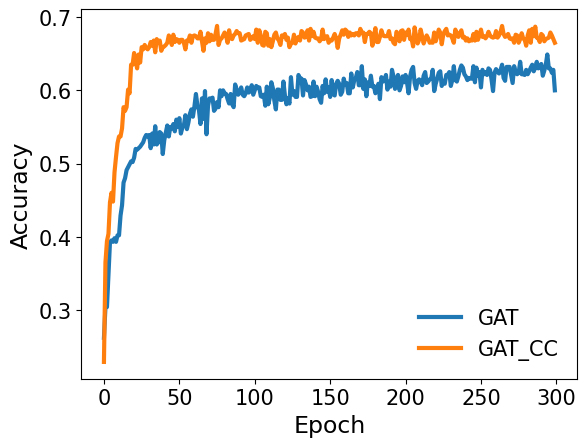

In [121]:


plt.plot(test_accs_dom,linewidth=3,label='GAT')
plt.plot(test_accs,linewidth=3,label='GAT_CC')
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend()
plt.xlabel("Epoch",fontsize = 17)
plt.ylabel("Accuracy",fontsize = 17)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

#plt.ylim(0,1)
#plt.legend(["blue", "green"], loc="lower right")
plt.legend(loc="lower right",frameon=False,fontsize = 15)
#for pos in ['right', 'top']: 
    #plt.gca().spines[pos].set_visible(False)
plt.savefig("CC_GAT.pdf",bbox_inches="tight")
plt.show

In [ ]:
plt.plot(test_accs_dom,label='GAT')
plt.plot(test_accs,label='CC_GAT')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig("CC_GAT.pdf")
plt.show